In [1]:
import numpy as np
import simulation_manager, results_annalysis
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
def P_aug(N,bit): 
    P = np.zeros((N,N*bit))
    b = np.array([2**i for i in range(bit)])
    for i in range(N):
        debut = i*bit
        fin = debut + bit 
        P[i,debut:fin] = b 

    return P 

In [3]:
P_aug(4,3)

array([[1., 2., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 2., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 2., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 4.]])

In [4]:
def reduction_markovitz(sigma,mu,alpha,K,bit=1,penaly = 0,compact= False):
    """
    From the covariance matrix and the excpected return vector returns the J and H 
    of the Ising mapping 

    ARGS: 
    sigma: covariance matrix 
    mu: excpected return vector
    alpha : aversion constant 
    K : The budget 
    penalty: If we add the constraint in the energy 
    Output: 
    J : 
    H: 
    """
    Bit_max = int(np.log2(K))
    bit = Bit_max
    N = len(mu) # Number of assets considered 
    U = np.ones(bit*N) 
    P = P_aug(N,bit)
    sigma_augmented = P.T @ sigma @ P
    mu_augmented = P.T @ mu 
    I_augmented = P.T @ np.ones(N)

    J = - (alpha/2)* sigma_augmented
    H = (alpha/2) * sigma_augmented @ U - mu_augmented - penaly*I_augmented
    np.fill_diagonal(J,0)

    if not compact: 
        return  J,H
    else: 
        # In here we will follow the methods used in paper 2023
        J_compact = np.zeros((len(J)+1,len(J)+1))
        J_compact[:len(J),:len(J)] = J
        J_compact[:len(J),len(J)] = H 
        J_compact[len(J),:len(J)] = H
        H_compact = np.zeros(len(H)+1)
        # H_compact[:len(H)] = H

        return J_compact,H_compact

In [5]:
def reverse(solution,N,K): 
    solution += 1
    solution /=2
    bit = int(np.log2(K))
    P = P_aug(N,bit)
    return P@solution

# **Testing the SB**

Defining $\Sigma$ and $\mu$

In [6]:
# Covariance matrix (example values)
sigma= np.array([[1.0, 1.2, 0.7], [1.2, 1.0, -1.9], [0.7, -1.9, 1.0]])

# Expected return vector (example values)
mu = np.array([0.2, 0.05, 0.17])



In [7]:
J,H = reduction_markovitz(sigma,mu,alpha = 2,K=10,bit=3,penaly= 1,compact=False)

In [8]:
np.log2(10)

3.321928094887362

In [9]:
eigs = np.linalg.eigvals(J)
ksi = 1/(eigs.max())
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())
num_iterations = 1000
lag = 0

def pumpuing_rate(self, t):
    # return t/100
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [10]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)

In [11]:
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()


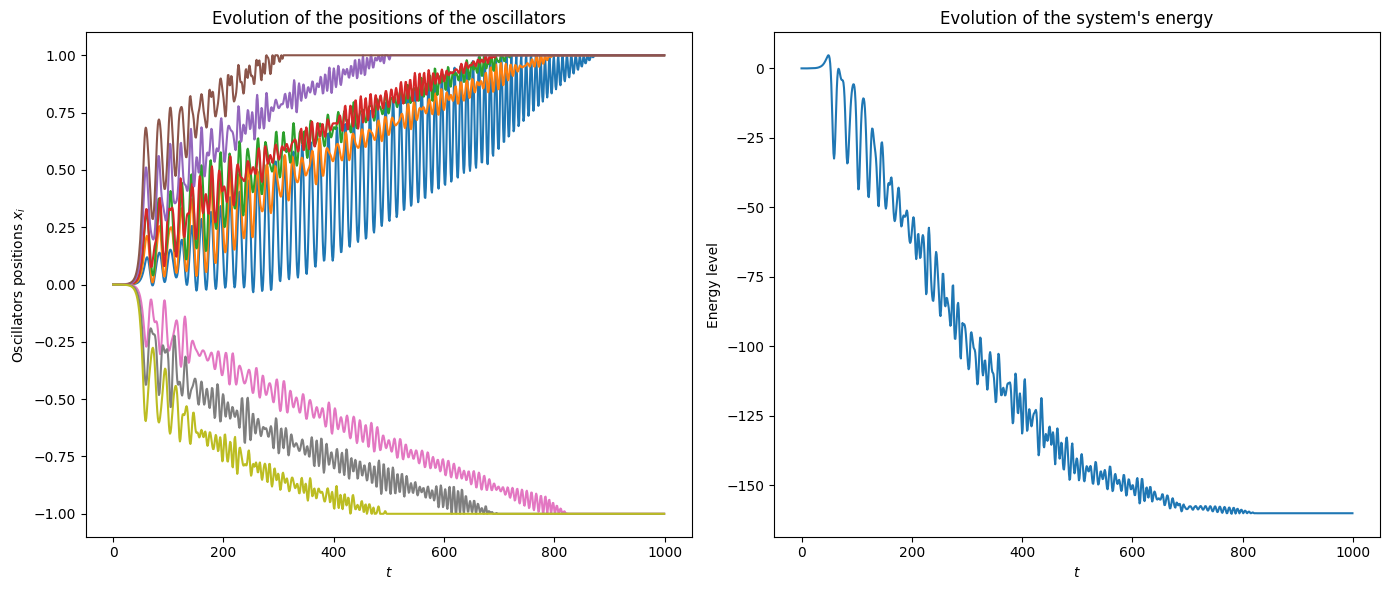

In [12]:
results_annalysis.complete_plot(states, energies, 0)


In [13]:
solution1 = np.sign(last_states[0, :, 0])
solution1

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.])

In [14]:
W_optimal1 = reverse(solution1,N = 3,K=10)
W_optimal1

array([7., 7., 0.])

# **Result analysis with random assets**

In [52]:
def geometric_brownian_motion(n_assets, n_time, initial_prices, drift=0.1, volatility=0.1):
    """Generate price paths from a geometric Brownian motion."""
    dt = 1  # Time step
    prices = np.zeros((n_assets, n_time))
    prices[:, 0] = initial_prices

    for i in range(n_assets):
        for t in range(1, n_time):
            prices[i, t] = prices[i, t - 1] * np.exp((drift - 0.5 * volatility**2) * dt +
                                                      volatility * np.sqrt(dt) * np.random.normal())

    return prices

def estimate_parameters(n_assets, n_time, initial_prices, drift=0.1, volatility=0.01):
    """Estimate future return vector μ and covariance matrix S."""
    prices = geometric_brownian_motion(n_assets, n_time, initial_prices, drift, volatility)
    returns = np.diff(prices, axis=1) / prices[:, :-1]
    mu = np.mean(returns, axis=1)
    S = np.cov(returns)
    return mu, S

# Example usage
N = 6 # Number of assets
T = 1000  # Number of time increments  

initial_prices = np.random.uniform(100,120,N)

# Here we explicitly set the drift term to the average expected return
mu, S = estimate_parameters(N, T, initial_prices=initial_prices, volatility=0.2)
print("Future return vector μ:\n", mu)
print("Covariance matrix S:\n", S)


Future return vector μ:
 [0.11733208 0.0881888  0.0875213  0.11192831 0.11690686 0.10137313]
Covariance matrix S:
 [[ 0.05006549 -0.00057075 -0.00033881  0.00225027 -0.00155039  0.00146528]
 [-0.00057075  0.04799061  0.00195742 -0.0020571  -0.00043993 -0.00131415]
 [-0.00033881  0.00195742  0.04695854 -0.00216343 -0.00047186  0.0014565 ]
 [ 0.00225027 -0.0020571  -0.00216343  0.05314895  0.00148468  0.00112571]
 [-0.00155039 -0.00043993 -0.00047186  0.00148468  0.05011137  0.00100664]
 [ 0.00146528 -0.00131415  0.0014565   0.00112571  0.00100664  0.0484372 ]]


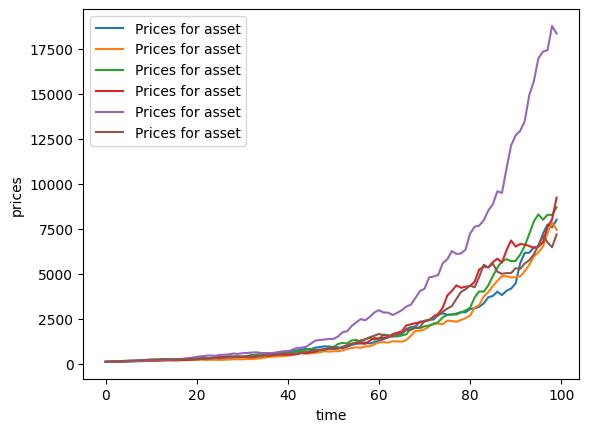

In [60]:
prices = geometric_brownian_motion(N, 100, initial_prices, drift = 0.05, volatility  = 0.05)
for i in range(N):
    plt.plot(np.arange(100),prices[i], label = 'Prices for asset')
plt.xlabel('time')
plt.ylabel('prices')
plt.legend()

plt.show()

In [53]:
J,H = reduction_markovitz(S,mu,K=75,alpha=5,penaly=0) 

In [54]:
eigs = np.linalg.eigvals(J)
ksi = 1/(eigs.max())
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())
num_iterations = 1000
lag = 0

def pumpuing_rate(self, t):
    # return t/100
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [55]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()

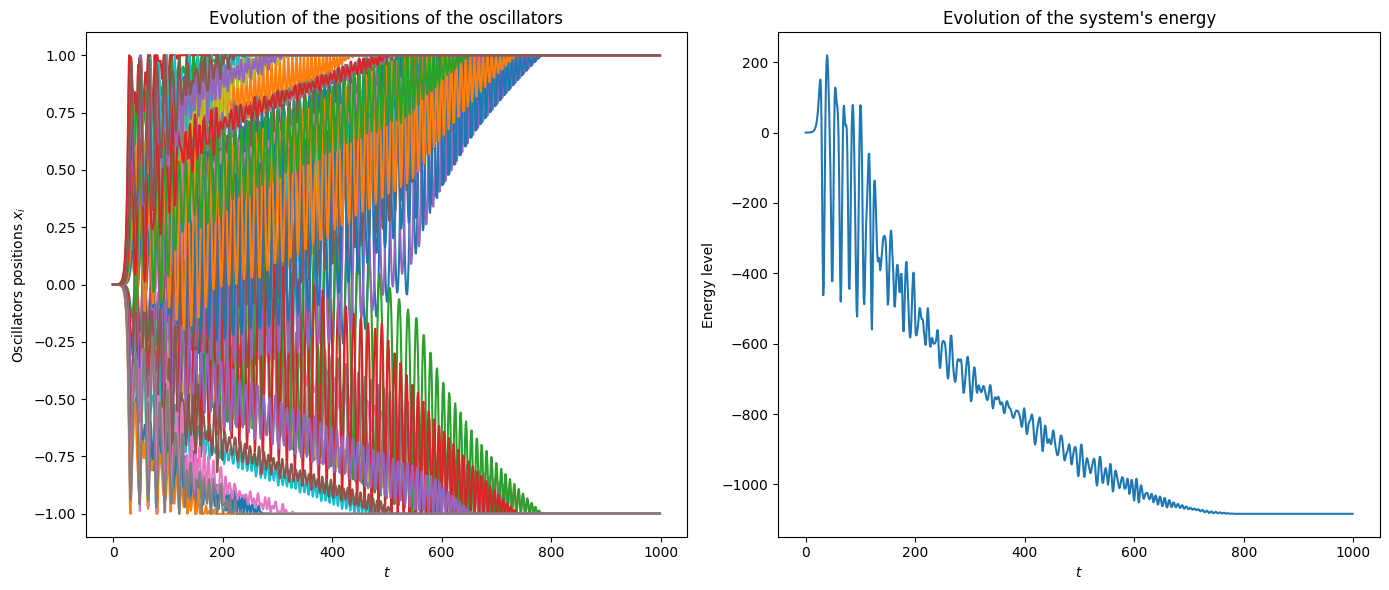

In [56]:
results_annalysis.complete_plot(states, energies, 0)

In [57]:
solution = np.sign(last_states[0, :, 0])
solution

array([ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [58]:
w_opt = reverse(solution,N,K=75)
w_opt  = w_opt/sum(w_opt)
w_opt

array([0.25, 0.  , 0.  , 0.25, 0.25, 0.25])

Show the universe of possible portfolios 

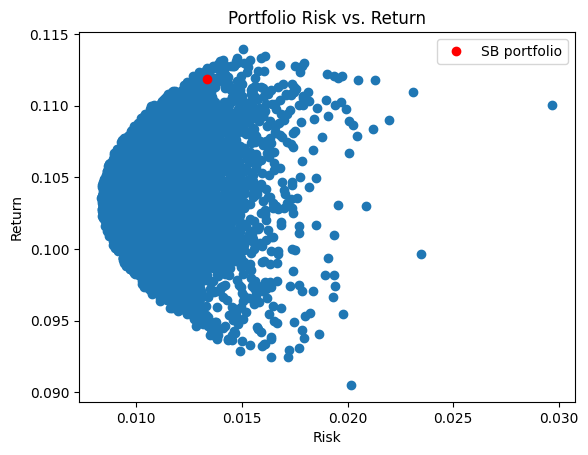

In [59]:
risque = []
retour = []

for _ in range(10000): 
    w = np.random.uniform(0, 75, N)
    w /= sum(w)
    wsw = w.T @ S @ w
    wmu = w.T @ mu

    risque.append(wsw)
    retour.append(wmu)

plt.scatter(risque, retour)
risque_SB = w_opt.T @ S @ w_opt 
return_SB = w_opt.T @ mu 
plt.plot(risque_SB, return_SB, 'ro', label='SB portfolio')  # Plot the SB portfolio point
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Portfolio Risk vs. Return')
plt.legend()
plt.show()
